In [1]:
import numpy as np
import pandas as pd
import pygplates
import gplately
from cmcrameri import cm
from collections import defaultdict

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from shapely.geometry import Polygon
from shapely.geometry import LineString


import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
#set directories
savedir = '/Users/andrew/Documents/Data/Gernon_shallow_ridges/'
# import previously made file in 'extract velocities'

rotfile = './data/Global_EarthByte_230-0Ma_GK07_AREPS.rot'
COBs = './data/Global_EarthByte_230-0Ma_GK07_AREPS_COB_Terranes.gpml'
coastlines = './data/Global_EarthByte_230-0Ma_GK07_AREPS_Coastlines.gpml'
topology_features = ['./data/Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml',
                     './data/Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpml']

rotation_model = pygplates.RotationModel(rotfile)

COBs = pygplates.FeatureCollection(COBs)
polygons = []
for feature in COBs:
    
    for geom in feature.get_geometries():
        polygon = []
        #print feature.get_geometry()
    
        polygon = feature
        polygon.set_geometry(pygplates.PolygonOnSphere(geom))

        #print polygon.get_geometry()

        polygons.append(polygon)

COBs = pygplates.FeatureCollection(polygons)
# Use the PlateReconstruction object to create a plate motion model
model = gplately.PlateReconstruction(rotation_model,
                                     topology_features,
                                     [COBs, coastlines])



In [3]:
#define our geographical regions
files = ['Afr-Ant','Afr-Mad', 'Aus-Ant', 'Aus-Mol', 'Central_Atlantic', 
         'Equatorial_Atlantic', 'Iberian_Atlantic', 'Ind-Aus-Ant','Ind-Mad', 
         'Labrador_sea', 'North_Atlantic', 'Southern_Atlantic']
#files = ['Afr-Ant','Afr-Mad']

In [4]:
gplot = gplately.plot.PlotTopologies(model, 50,
                                     COB_filename=model.static_polygons[0],
                                     coastline_filename=model.static_polygons[1])



In [19]:
polys = pygplates.FeatureCollection('./data/ridge_polygons/gmt/Afr-Ant_124.gmt')

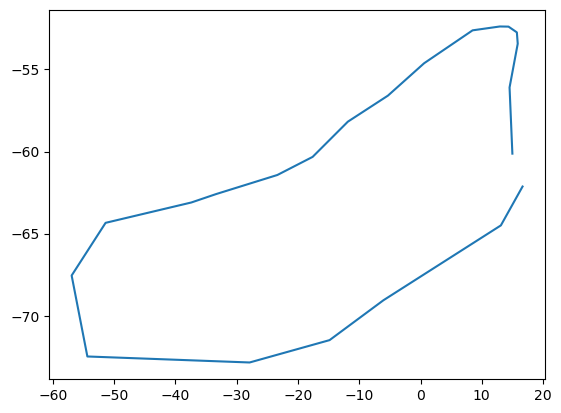

In [21]:
for i in polys:
    plt.plot(i.get_geometry().to_lat_lon_array()[:,1],
             i.get_geometry().to_lat_lon_array()[:,0])


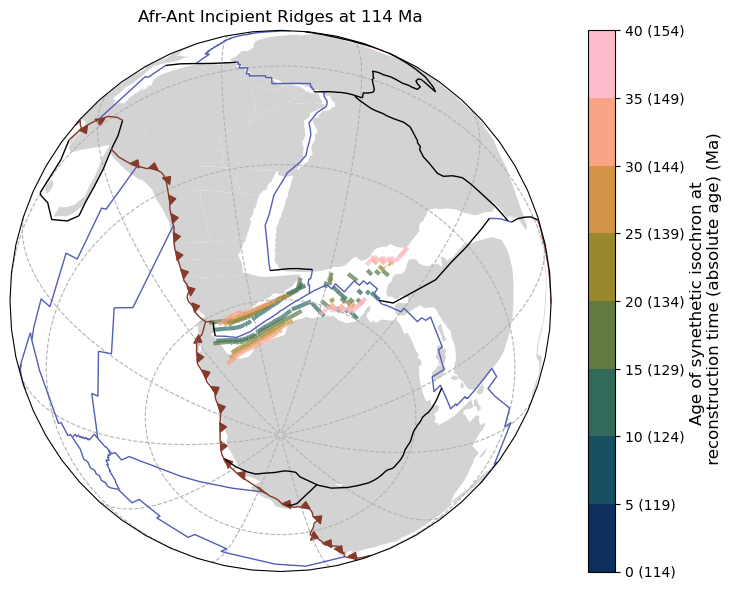

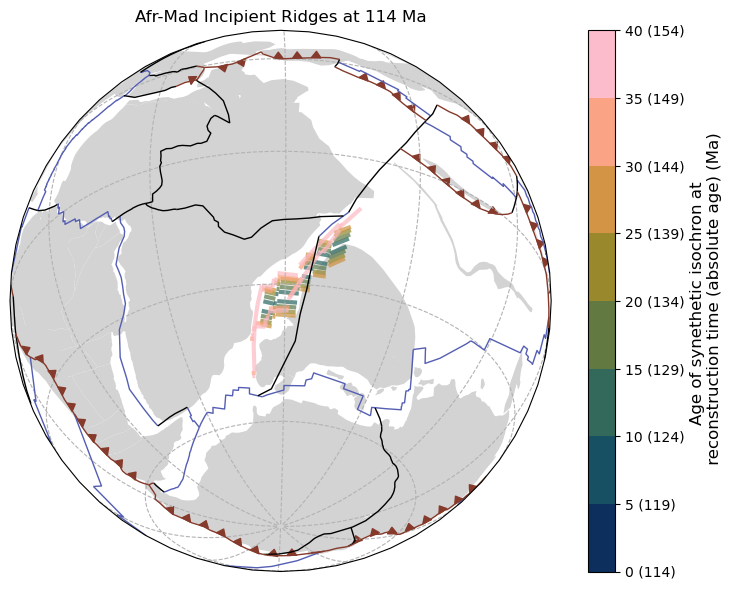

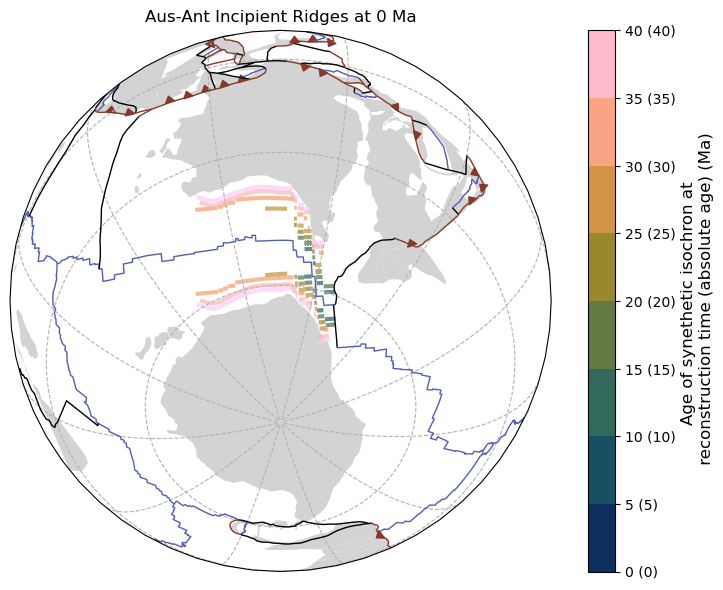

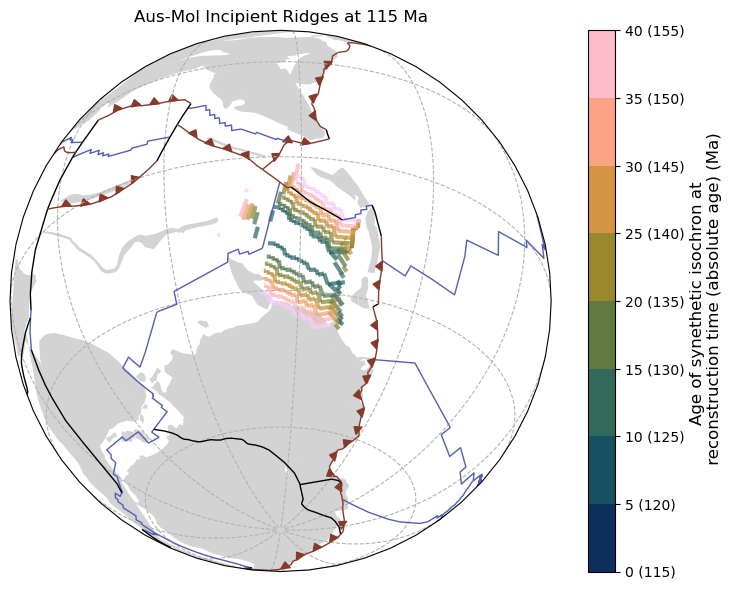

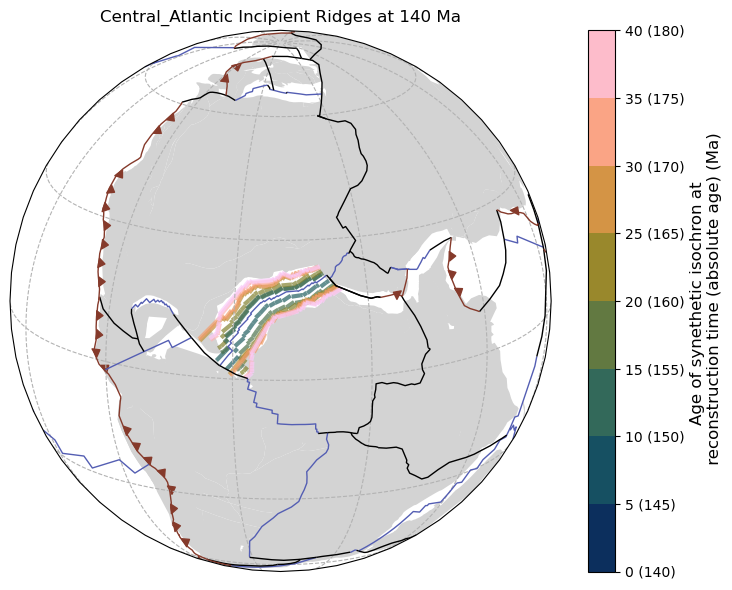

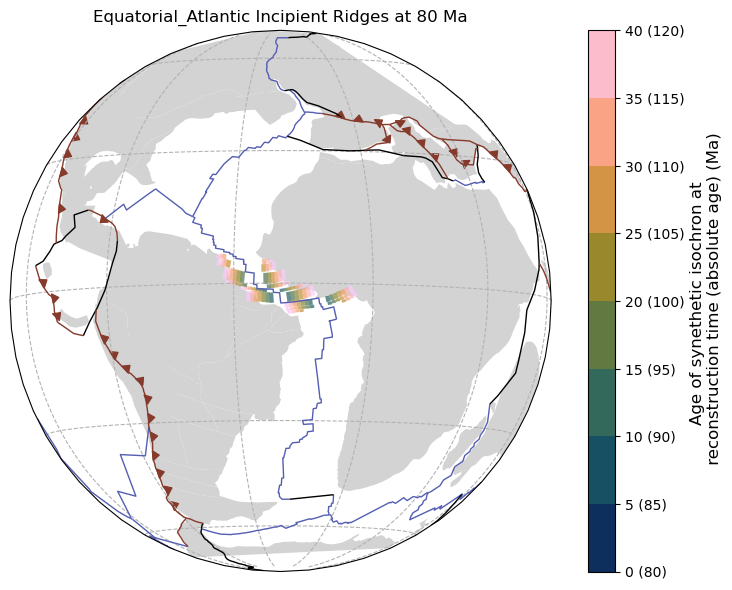

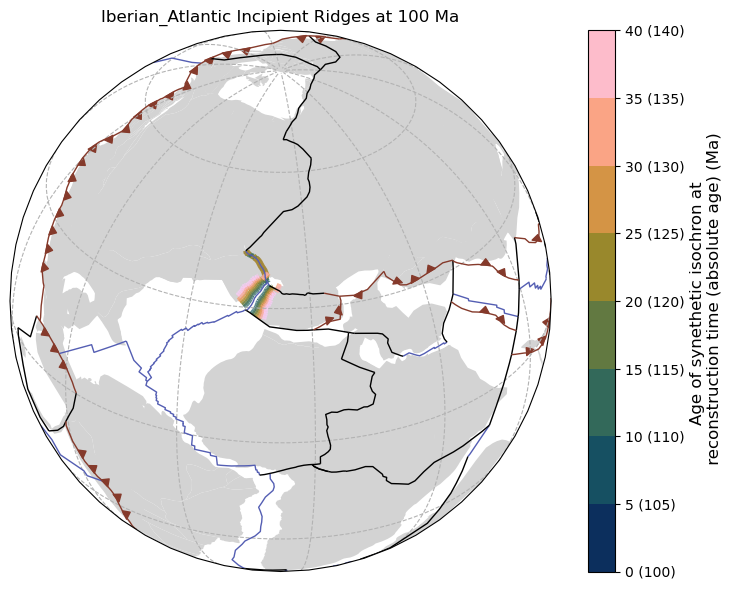

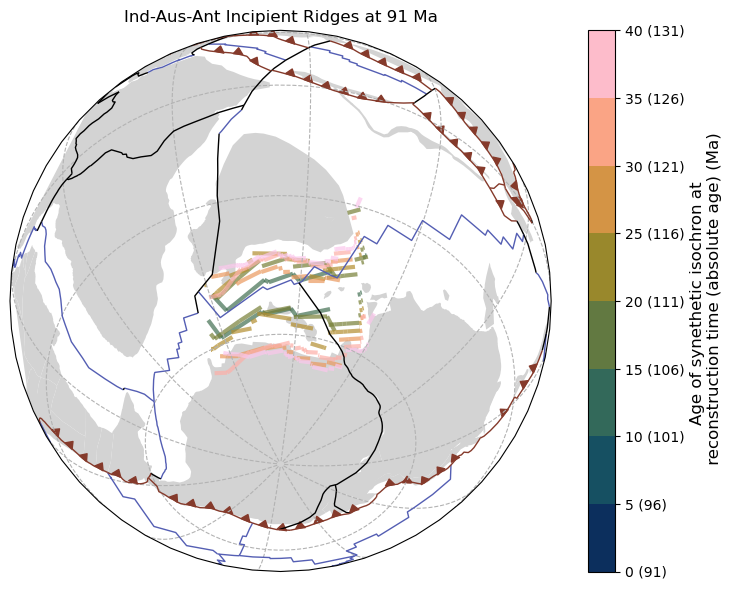

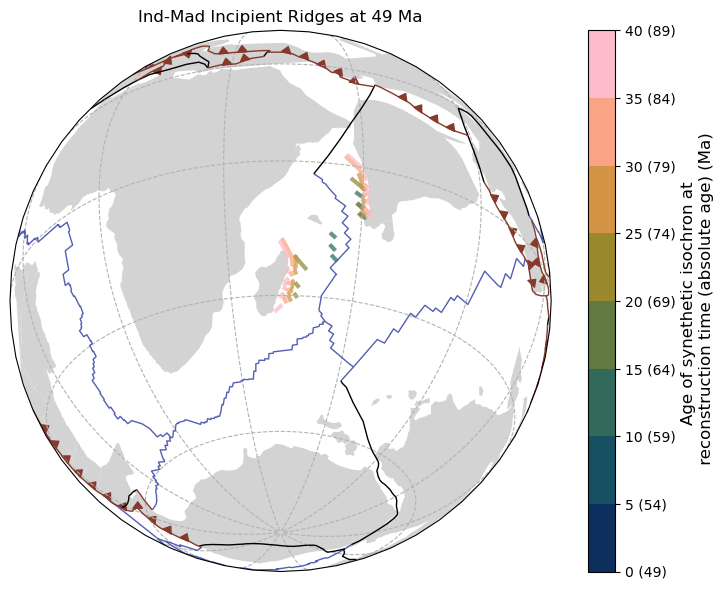

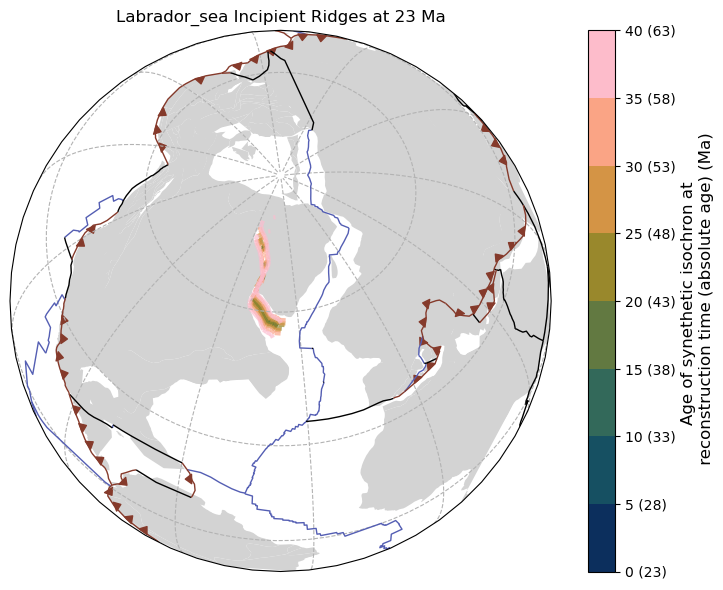

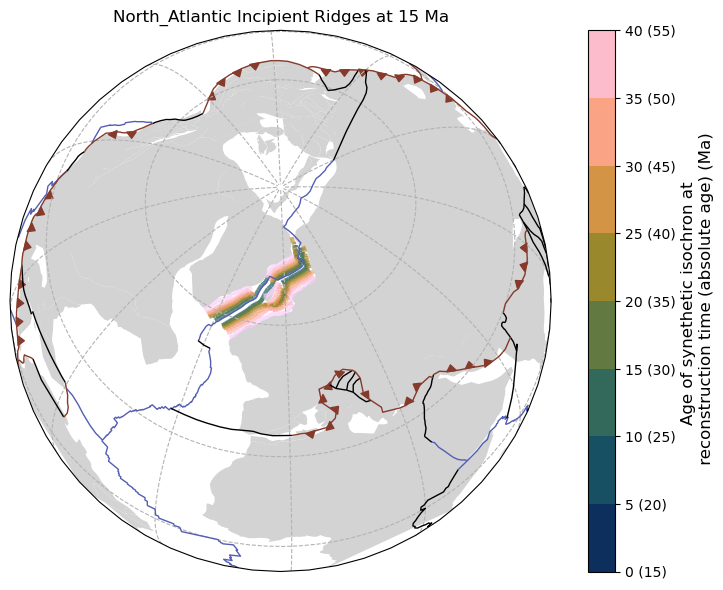

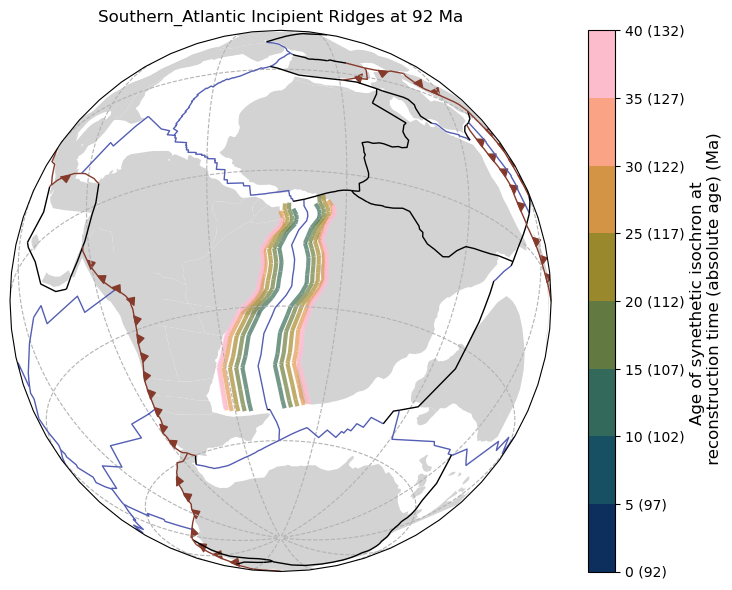

In [40]:
#plot final results

cmap = cm.batlow
colour_map = cmap(np.linspace(0, 1, 41))
for file in files[:]:#load data
    
    df = pd.read_csv(f'./results/COMBINED_RIDGES/{file}.csv',  index_col=None)
    plot_time = np.max(df['Time_Ma'].min()-10, 0)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6),
                           subplot_kw={'projection': ccrs.Orthographic(df['MeanPointLon'].mean(),
                                                                       df['MeanPointLat'].mean())})
    ax.set_global()    
    ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,30), ylocs=np.arange(-90,90,30))
   #for i in polys:
   #    #ax.plot(i.get_geometry().to_lat_lon_array()[:,1],
   #    #           i.get_geometry().to_lat_lon_array()[:,0], crs=ccrs.Geodetic)
   #    poly = Polygon(zip(i.get_geometry().to_lat_lon_array()[:,1],
   #                       i.get_geometry().to_lat_lon_array()[:,0]))
   #    ax.add_geometries([poly], crs=ccrs.Geodetic())
        
    #plot our ridge data
    for ind, row in df.iterrows():
        time = row[10]
        if time % 5 != 0:
            continue
#
        points = np.array([row[2], row[3], row[4], row[5]])
        point = np.array([row[1], row[0]])
        polyline = pygplates.PolylineOnSphere(zip(points[::2],points[1::2]))
        mid_point = pygplates.PointOnSphere(point)
        left_plate = row[7]
        right_plate = row[8]
#
        rotation_right = rotation_model.get_rotation(int(plot_time), int(right_plate), int(time))
        rotation_left = rotation_model.get_rotation(int(plot_time), int(left_plate), int(time))
        reconstructed_line_right = rotation_right * polyline
        reconstructed_line_left = rotation_left * polyline
#
        colour_time = int(time)- plot_time
#
        #right rotation
        lat_lon_array = reconstructed_line_right.get_points().to_lat_lon_array()
        lats = lat_lon_array[:,0]
        lons = lat_lon_array[:,1]
#
        line = LineString(zip(lons,lats))
        data = ax.add_geometries([line], crs=ccrs.PlateCarree(), color=colour_map[colour_time], alpha=0.7, lw=3)
#
        #left rotation
        lat_lon_array = reconstructed_line_left.get_points().to_lat_lon_array()
        lats = lat_lon_array[:,0]
        lons = lat_lon_array[:,1]
#
        line = LineString(zip(lons,lats))
        ax.add_geometries([line], crs=ccrs.PlateCarree(), color=colour_map[colour_time], alpha=0.7, lw=3)

    
    plt.title(f'{file} Incipient Ridges at {plot_time} Ma')

    # Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
    gplot.time = plot_time # Ma
    gplot.plot_continent_ocean_boundaries(ax, color='lightgrey', alpha=1)
    #gplot.plot_coastlines(ax, color='grey', alpha=0.6)
    gplot.plot_ridges_and_transforms(ax, color='#545eb3', linewidth=1)
    gplot.plot_misc_boundaries(ax, color='k', linewidth=1)
    gplot.plot_trenches(ax, color='#853a2b', linewidth=1)
    gplot.plot_subduction_teeth(ax, color='#853a2b', linewidth=1)

    norm = mpl.colors.Normalize(vmin=0,vmax=41)
    #cmap = cm.batlow(41)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    #sm.set_array([])
    cbar = fig.colorbar(sm, boundaries=np.arange(0,41,5))
    cbar_ticks = []
    for tick in cbar.ax.get_yticks():
        cbar_ticks.append(str(int(tick)) + ' (' + str(int(tick+plot_time)) +')')
    cbar.ax.set_yticklabels(cbar_ticks) 
    
    cbar.set_label('Age of synethetic isochron at \n reconstruction time (absolute age) (Ma)', fontsize=12)
    cbar.ax.tick_params(labelsize=10) 

    fig.tight_layout()
    fig.savefig(f'./results/figures/{file}_incipient_ridges.pdf')

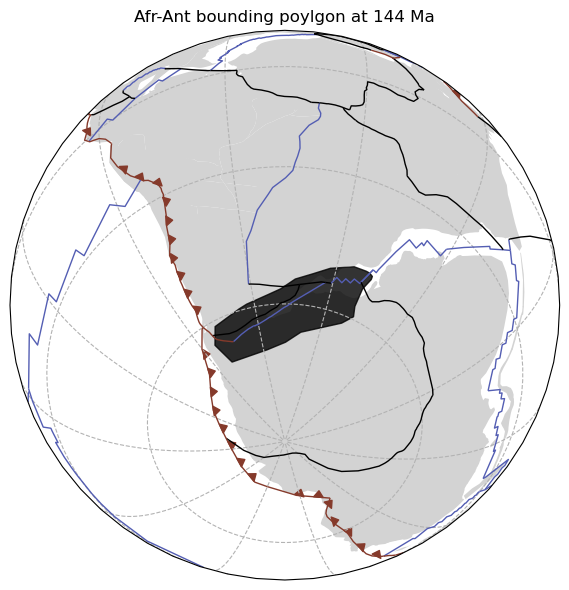

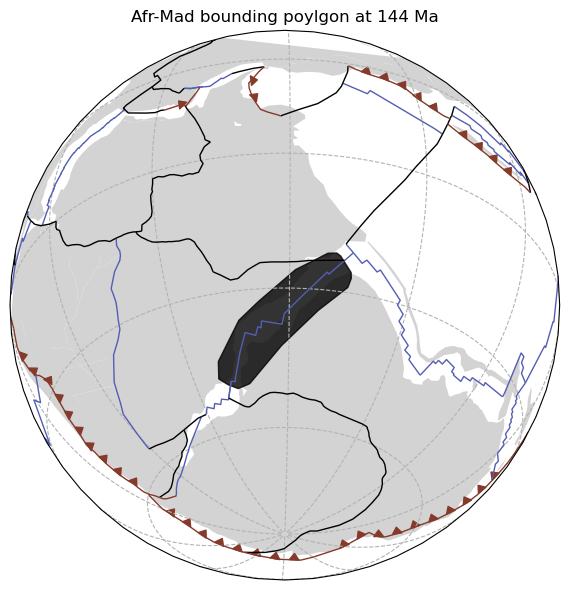

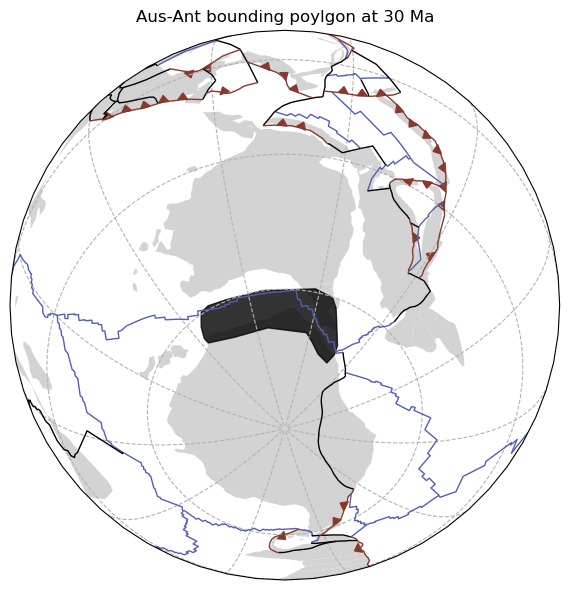

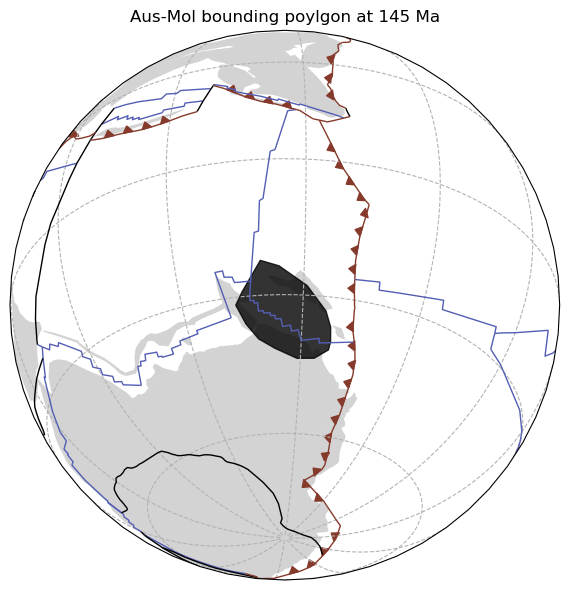

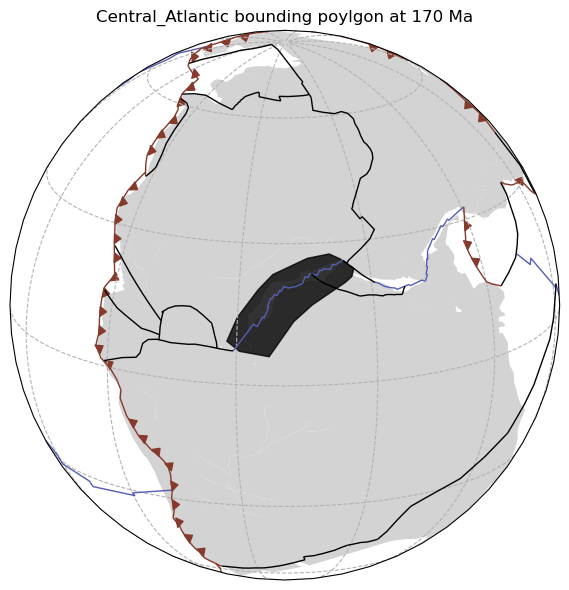

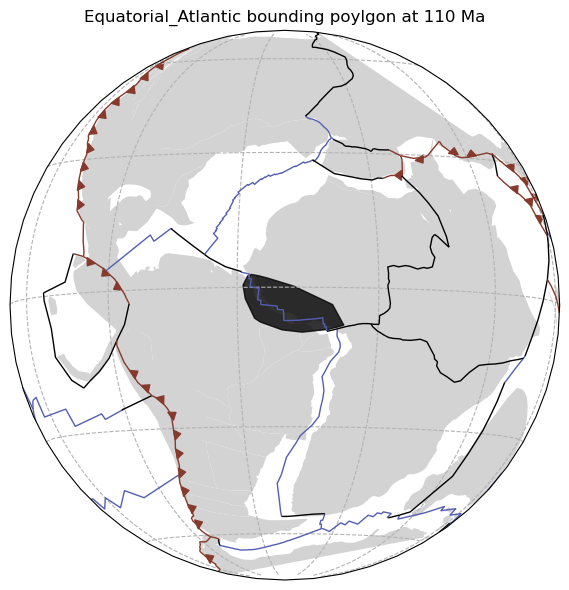

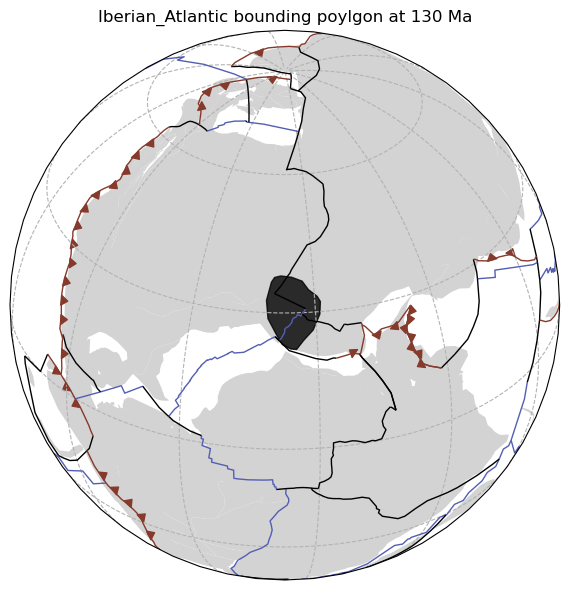

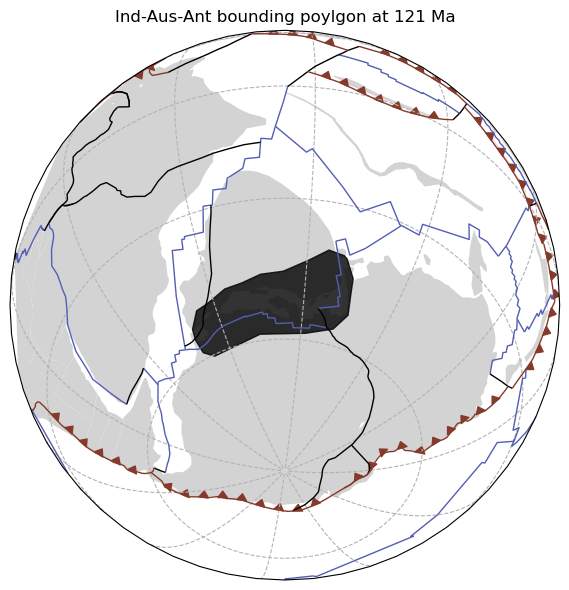

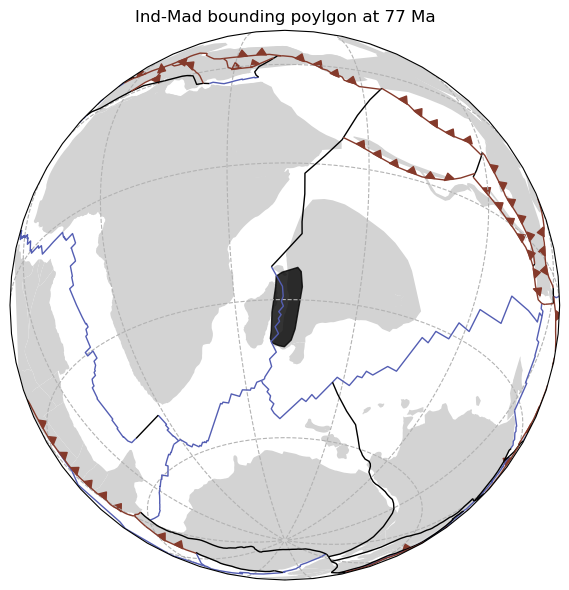

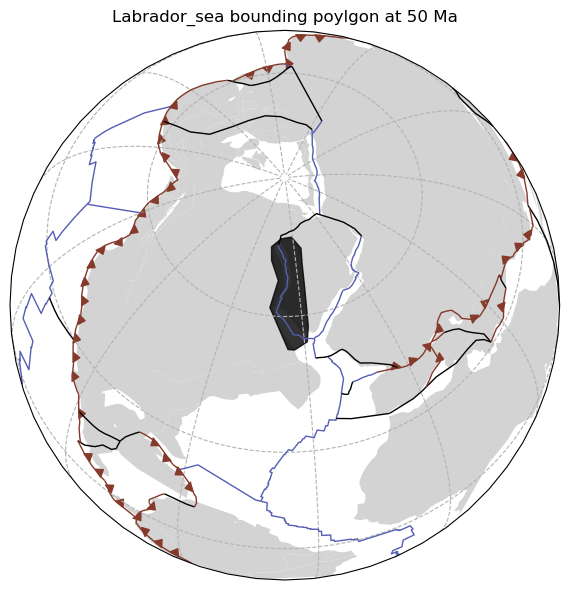

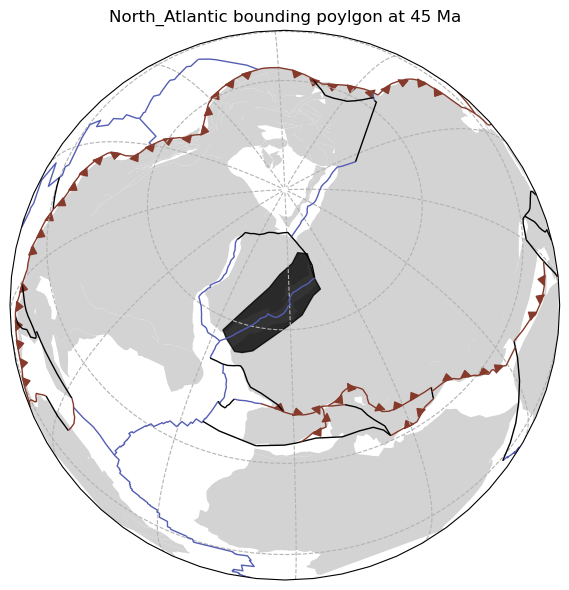

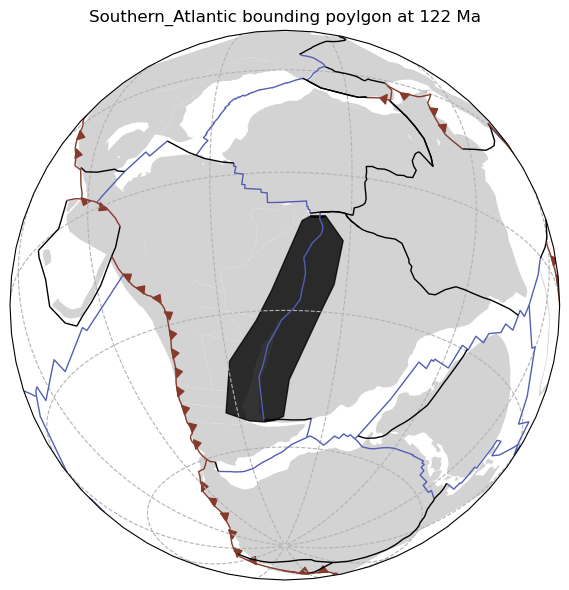

In [38]:
#plot final results

cmap = cm.batlow
colour_map = cmap(np.linspace(0, 1, 41))
for file in files[:]:
    
    df = pd.read_csv(f'./results/COMBINED_RIDGES/{file}.csv',  index_col=None)
    plot_time = np.max(df['Time_Ma'].max()-10)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6),
                           subplot_kw={'projection': ccrs.Orthographic(df['MeanPointLon'].mean(),
                                                                       df['MeanPointLat'].mean())})
    ax.set_global()    
    ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,30), ylocs=np.arange(-90,90,30))

    #load bounding polygon
    polys = pygplates.FeatureCollection(f'./data/ridge_polygons/gmt/{file}_{plot_time}.gmt')
    for node in polys:
        poly = Polygon(zip(node.get_geometry().to_lat_lon_array()[:,1],
                           node.get_geometry().to_lat_lon_array()[:,0]))
        ax.add_geometries([poly], crs=ccrs.PlateCarree(),color='k', alpha=0.8)
        
    
    plt.title(f'{file} bounding poylgon at {plot_time} Ma')

    # Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
    gplot.time = plot_time # Ma
    gplot.plot_continent_ocean_boundaries(ax, color='lightgrey', alpha=1)
    #gplot.plot_coastlines(ax, color='grey', alpha=0.6)
    gplot.plot_ridges_and_transforms(ax, color='#545eb3', linewidth=1)
    gplot.plot_misc_boundaries(ax, color='k', linewidth=1)
    gplot.plot_trenches(ax, color='#853a2b', linewidth=1)
    gplot.plot_subduction_teeth(ax, color='#853a2b', linewidth=1)

    fig.tight_layout()
    fig.savefig(f'./results/figures/{file}_bounding_poly.pdf')